C:\Users\xiaoy\AppData\Local\Temp\ipykernel_11392\2025239419.py:101: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_final_combined = linkage(final_combined_dist_matrix_filtered, method='complete')


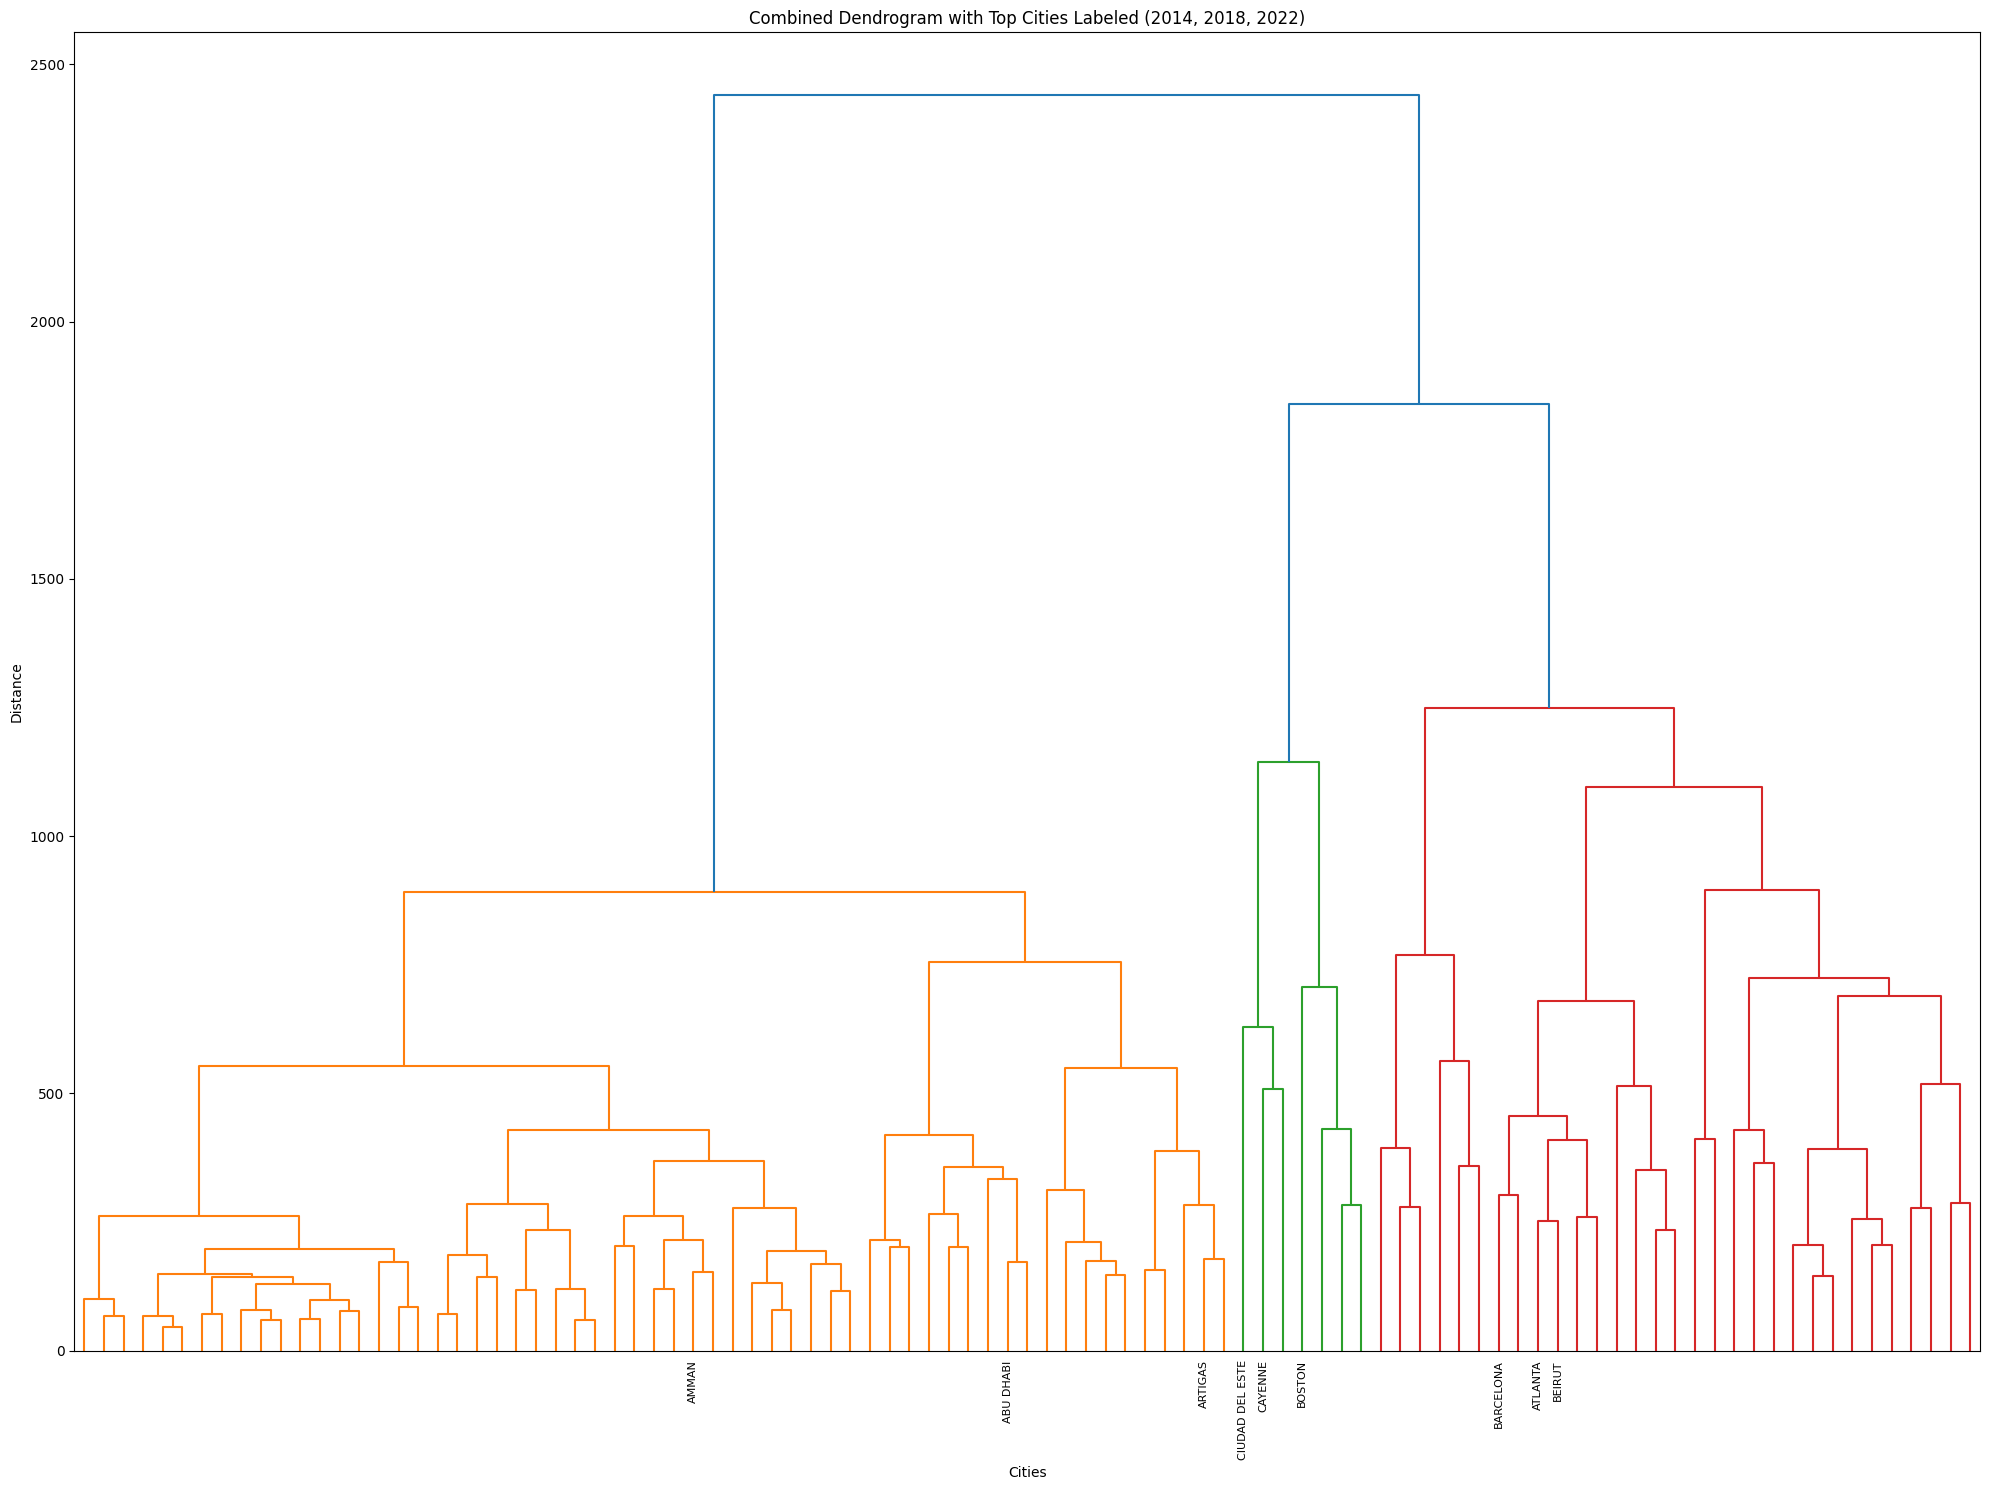

D:\python\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


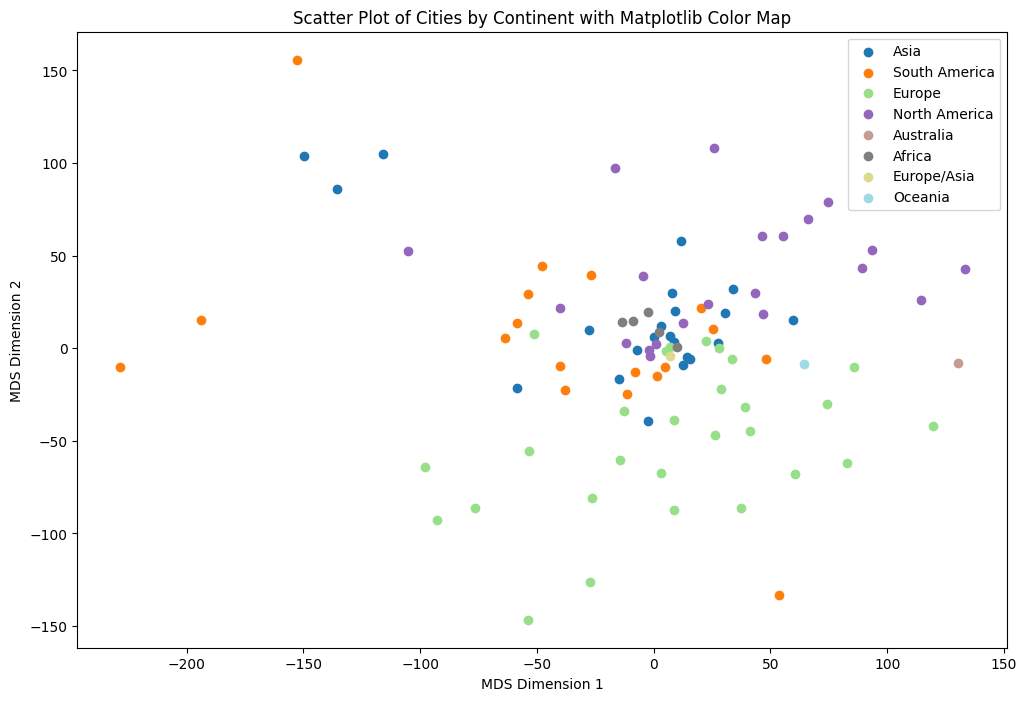

('Desktop/combined_dendrogram.png', 'Desktop/cities_scatter_plot.png')

In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.manifold import MDS
import matplotlib.pyplot as plt


# Load the datasets
file_path_2022 = 'Desktop/CLEANZZ22.csv'  # Adjust this path as needed
file_path_2014 = 'Desktop/CLEANZZ14.csv'
file_path_2018 = 'Desktop/CLEANZZ18.csv'

df_2022 = pd.read_csv(file_path_2022, encoding='ISO-8859-1')
df_2014 = pd.read_csv(file_path_2014, encoding='ISO-8859-1')
df_2018 = pd.read_csv(file_path_2018, encoding='ISO-8859-1')

# Function to create a long format dataframe
def create_long_format(df):
    return df.loc[df.index.repeat(df['NUMBER_OF_VOTERS_PROFILE'])]

# Function to create wide format dataframes for each category
def create_wide_format(df_long):
    df_wide_ms = df_long.pivot_table(index='CITY_NAME', columns='MARITAL_STATUS_CODE', values='NUMBER_OF_VOTERS_PROFILE', aggfunc='size', fill_value=0)
    df_wide_gender = df_long.pivot_table(index='CITY_NAME', columns='GENDER_CODE', values='NUMBER_OF_VOTERS_PROFILE', aggfunc='size', fill_value=0)
    df_wide_education = df_long.pivot_table(index='CITY_NAME', columns='EDUCATION_LEVEL_CODE', values='NUMBER_OF_VOTERS_PROFILE', aggfunc='size', fill_value=0)
    df_wide_age = df_long.pivot_table(index='CITY_NAME', columns='AGE_GROUP_CODE', values='NUMBER_OF_VOTERS_PROFILE', aggfunc='size', fill_value=0)
    return df_wide_ms, df_wide_gender, df_wide_education, df_wide_age

# Process 2022 data and filter cities
df_long_2022 = create_long_format(df_2022)
df_wide_ms_2022, df_wide_gender_2022, df_wide_education_2022, df_wide_age_2022 = create_wide_format(df_long_2022)
filtered_cities_2022 = df_wide_age_2022[df_wide_age_2022.sum(axis=1) >= 110].index

# Apply the same set of cities for 2014 and 2018 data
df_2014 = df_2014[df_2014['CITY_NAME'].isin(filtered_cities_2022)]
df_2018 = df_2018[df_2018['CITY_NAME'].isin(filtered_cities_2022)]
# Custom distance functions for categorical and ordinal data
def cat_dist(x, y, normalize=False):
    wx, wy = np.sum(x), np.sum(y)
    m = (x + y) / (wx + wy)
    x, y = x / wx, y / wy
    return np.sqrt(wx * l2_dist(x, m)) + np.sqrt(wy * l2_dist(y, m))

def ord_dist(x, y, normalize=False):
    wx, wy = np.sum(x), np.sum(y)
    x, y = np.cumsum(x)[:-1], np.cumsum(y)[:-1]
    m = (x + y) / (wx + wy)
    x, y = x / wx, y / wy
    return np.sqrt(wx * l2_dist(x, m)) + np.sqrt(wy * l2_dist(y, m))

def l2_dist(x, y):
    return np.sum((x - y) ** 2)

# Process each year's data

df_long_2014 = create_long_format(df_2014)
df_wide_ms_2014, df_wide_gender_2014, df_wide_education_2014, df_wide_age_2014 = create_wide_format(df_long_2014)

df_long_2018 = create_long_format(df_2018)
df_wide_ms_2018, df_wide_gender_2018, df_wide_education_2018, df_wide_age_2018 = create_wide_format(df_long_2018)

# Ensure the same set of cities in the same order for all years
common_cities = set(df_wide_ms_2022.index) & set(df_wide_ms_2014.index) & set(df_wide_ms_2018.index)

def filter_common_cities(df_wide, common_cities):
    return df_wide.loc[df_wide.index.isin(common_cities)]

df_wide_ms_2022_filtered = filter_common_cities(df_wide_ms_2022, common_cities)
df_wide_gender_2022_filtered = filter_common_cities(df_wide_gender_2022, common_cities)
df_wide_education_2022_filtered = filter_common_cities(df_wide_education_2022, common_cities)
df_wide_age_2022_filtered = filter_common_cities(df_wide_age_2022, common_cities)

df_wide_ms_2014_filtered = filter_common_cities(df_wide_ms_2014, common_cities)
df_wide_gender_2014_filtered = filter_common_cities(df_wide_gender_2014, common_cities)
df_wide_education_2014_filtered = filter_common_cities(df_wide_education_2014, common_cities)
df_wide_age_2014_filtered = filter_common_cities(df_wide_age_2014, common_cities)

df_wide_ms_2018_filtered = filter_common_cities(df_wide_ms_2018, common_cities)
df_wide_gender_2018_filtered = filter_common_cities(df_wide_gender_2018, common_cities)
df_wide_education_2018_filtered = filter_common_cities(df_wide_education_2018, common_cities)
df_wide_age_2018_filtered = filter_common_cities(df_wide_age_2018, common_cities)

# Function to calculate combined distance matrix for each year
def calculate_combined_distance_matrix(df_wide_ms, df_wide_gender, df_wide_education, df_wide_age):
    dist_matrix_ms = squareform(pdist(df_wide_ms, metric=cat_dist))
    dist_matrix_gender = squareform(pdist(df_wide_gender, metric=cat_dist))
    dist_matrix_education = squareform(pdist(df_wide_education, metric=ord_dist))
    dist_matrix_age = squareform(pdist(df_wide_age, metric=ord_dist))
    return dist_matrix_ms + dist_matrix_gender + dist_matrix_education + dist_matrix_age

# Calculate combined distance matrices for each year
combined_dist_matrix_2022_filtered = calculate_combined_distance_matrix(df_wide_ms_2022_filtered, df_wide_gender_2022_filtered, df_wide_education_2022_filtered, df_wide_age_2022_filtered)
combined_dist_matrix_2014_filtered = calculate_combined_distance_matrix(df_wide_ms_2014_filtered, df_wide_gender_2014_filtered, df_wide_education_2014_filtered, df_wide_age_2014_filtered)
combined_dist_matrix_2018_filtered = calculate_combined_distance_matrix(df_wide_ms_2018_filtered, df_wide_gender_2018_filtered, df_wide_education_2018_filtered, df_wide_age_2018_filtered)

# Combine the distance matrices from 2014, 2018, and 2022 after filtering
final_combined_dist_matrix_filtered = combined_dist_matrix_2022_filtered + combined_dist_matrix_2014_filtered + combined_dist_matrix_2018_filtered

# Perform hierarchical clustering on the final combined distance matrix
Z_final_combined = linkage(final_combined_dist_matrix_filtered, method='complete')

# Using a distance threshold of 3900 to identify clusters
clusters = fcluster(Z_final_combined, t=1500, criterion='distance')

# Creating a DataFrame to map cities to their clusters
cluster_mapping = pd.DataFrame({'City': df_wide_ms_2022_filtered.index, 'Cluster': clusters})

# Grouping by cluster and finding the top 3 cities by population within each cluster
top_cities_per_cluster = cluster_mapping.groupby('Cluster')['City'].apply(lambda x: x.head(3)).reset_index(drop=True)

# Extracting the city names for highlighting in the dendrogram
highlighted_cities = top_cities_per_cluster.values

# Creating a label function to only show the top cities
def llf(id):
    if df_wide_ms_2022_filtered.index[id] in highlighted_cities:
        return df_wide_ms_2022_filtered.index[id]
    else:
        return ''

# Plotting the dendrogram with labels for top cities only
plt.figure(figsize=(20, 15))
dendrogram(Z_final_combined, labels=df_wide_ms_2022_filtered.index, leaf_label_func=llf, leaf_rotation=90, leaf_font_size=8)
plt.title("Combined Dendrogram with Top Cities Labeled (2014, 2018, 2022)")
plt.xlabel('Cities')
plt.ylabel('Distance')
plt.axhline(y=3900, color='r', linestyle='--')
plt.tight_layout()
plt.show()



# Extracting continent information
continent_info = df_2022.set_index('CITY_NAME')['CONTINENT']
continent_info_filtered = continent_info[continent_info.index.isin(common_cities)]

# Performing Multidimensional Scaling (MDS)
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
mds_result = mds.fit_transform(final_combined_dist_matrix_filtered)

# Extracting the MDS coordinates
mds_x = mds_result[:, 0]
mds_y = mds_result[:, 1]

# Creating the scatter plot with distinct colors for each continent
plt.figure(figsize=(12, 8))
cmap = plt.get_cmap('tab20', len(continent_info_filtered.unique()))
for i, continent in enumerate(continent_info_filtered.unique()):
    idx = continent_info_filtered[continent_info_filtered == continent].index
    plt.scatter(mds_x[df_wide_ms_2022_filtered.index.isin(idx)], mds_y[df_wide_ms_2022_filtered.index.isin(idx)], label=continent, color=cmap(i))
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.title('Scatter Plot of Cities by Continent with Matplotlib Color Map')
plt.legend()
plt.show()

# Re-generating the dendrogram with highlighted top cities for output
plt.figure(figsize=(20, 15))
dendrogram(Z_final_combined, labels=df_wide_ms_2022_filtered.index, leaf_label_func=llf, leaf_rotation=90, leaf_font_size=12)  # Increase leaf font size
plt.title("Combined Dendrogram with Top Cities Labeled (2014, 2018, 2022)", fontsize=30)  # Increase title font size
plt.xlabel('Cities', fontsize=25)  # Increase xlabel font size
plt.ylabel('Distance', fontsize=25)  # Increase ylabel font size
plt.tick_params(axis='x', labelsize=20)  # Increase x-axis tick font size
plt.tick_params(axis='y', labelsize=20)  # Increase y-axis tick font size
plt.axhline(y=3900, color='r', linestyle='--')
plt.tight_layout()
dendrogram_path = 'Desktop/combined_dendrogram.png'
plt.savefig(dendrogram_path)
plt.close()


# Re-generating the scatter plot with distinct colors for each continent for output
plt.figure(figsize=(12, 8))
cmap = plt.get_cmap('tab20', len(continent_info_filtered.unique()))
for i, continent in enumerate(continent_info_filtered.unique()):
    idx = continent_info_filtered[continent_info_filtered == continent].index
    plt.scatter(mds_x[df_wide_ms_2022_filtered.index.isin(idx)], mds_y[df_wide_ms_2022_filtered.index.isin(idx)], label=continent, color=cmap(i))

plt.xlabel('MDS Dimension 1', fontsize=18)  # Increase xlabel font size
plt.ylabel('MDS Dimension 2', fontsize=18)  # Increase ylabel font size
plt.title('Scatter Plot of Cities by Continent with Matplotlib Color Map', fontsize=22)  # Increase title font size
plt.tick_params(axis='both', which='major', labelsize=15)  # Increase x and y axes tick font size
plt.legend(fontsize=10)  # Increase legend font size

scatter_plot_path = 'Desktop/cities_scatter_plot.png'
plt.savefig(scatter_plot_path)
plt.close()



dendrogram_path, scatter_plot_path





